# Detect AI generated text using Naive Bayes Classification

Import required libraries

In [2]:
import pandas as pd
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
training_data = pd.read_csv('train_essays.csv')
training_data

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0
...,...,...,...,...
1383,86hfhd2,1,I am writing to express my perspective on the ...,1
1384,970wesgs,1,I hope this letter finds you well. I am writin...,1
1385,9831fsdga1,1,I trust this letter reaches you in good health...,1
1386,983495erg,1,I hope this letter reaches you in good health ...,1


In [4]:
prompt_data = pd.read_csv('train_prompts.csv')
prompt_data.head()

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


In [5]:
testing_data = pd.read_csv('test_essays.csv')
testing_data

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.
3,3452ffdsdd,5,I trust this letter finds you well and engaged...


In [24]:
class NBC:
    def __init__(self,data,min_threshold):
        
        words = {}
        words_dep = {}
        
        ### count number of essays containing specific words ###
        for index,row in data.iterrows():
            ws = nltk.word_tokenize(row['text'])
            word_freq = nltk.FreqDist(ws)
            #word_freq = convert_essay_to_freq(row['essay'])
            for key,val in word_freq.items():
                if key in words.keys():words[key]+=1
                else:words[key]=1
                if key in words_dep.keys() and row['generated']:words_dep[key]+=1
                else:words_dep[key]=0
                    
        ### Store all values in model ###
        self.__threshold = min_threshold
        self.__N = len(data)
        self.__gen = len(data[data['generated']==1])
        self.__words = words
        self.__wordsgen = words_dep
        
    
    def predict(self,essay):
        ws = nltk.word_tokenize(row['text'])
        word_freq = nltk.FreqDist(ws)
        
        pw = 1
        pwg = 1
        total = self.__N
        gen = self.__gen
        
        ### apply softening where P can be 0 ###
        for key in word_freq.keys():
            if key in self.__words.keys():
                if self.__words[key]<=0:
                    total+=1
                    self.__words[key]+=1
                if self.__wordsgen[key]<=0:
                    gen+=1
                    self.__wordsgen[key]+=1
        
        ## calculate probabilities ###
        for key,val in word_freq.items():
            if val >= self.__threshold and key in self.__words.keys():
                pw *= self.__words[key]/total
                pwg*= self.__wordsgen[key]/gen
        
        return (pwg*(self.__gen/self.__N))/pw
    
    def plot_data(self):
        plt.bar(range(len(self.__words)), list(self.__words.values()))
        plt.bar(range(len(self.__wordsgen)), list(self.__wordsgen.values()))
        plt.show()

In [25]:
model = NBC(training_data,2)

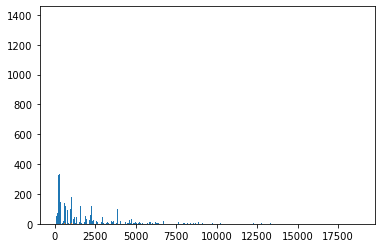

In [26]:
model.plot_data()

In [27]:
final_dt = pd.DataFrame([],columns=['id','generated'])
for index,row in testing_data.iterrows():
    final_dt.loc[len(final_dt)]={'id':row['id'],'generated':model.predict(row['text'])}
final_dt.head()

,id,generated
0,0000aaaa,9.365994e-03
1,1111bbbb,9.365994e-03
2,2222cccc,9.365994e-03
3,3452ffdsdd,7.485547e-08


In [28]:
final_dt.to_csv('submission.csv',index=False)